In [1]:
from platform import python_version
print(python_version())

3.9.7


In [2]:
# Code from Book: Build Your Own AI Investor
# Damon Lee 2020
# Check out the performance on www.valueinvestingai.com
# Code uses data from the (presumably) nice people at https://simfin.com/. 
# Feel free to fork this code for others to see what can be done with it.

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import math

In [6]:
''' LEER DATOS DEL ULTIMO NOTEBOOK'''
x_=pd.read_csv(\
       "Annual_Stock_Price_Fundamentals_Filtered.csv",\
       index_col=0)
y_=pd.read_csv(\
       "Annual_Stock_Price_Performance_Filtered.csv",\
       index_col=0)

# ANTES

In [7]:
x_

,Ticker,SimFinId,Currency,Fiscal Year,Fiscal Period_x,Report Date,Publish Date,Restated Date_x,Shares (Basic)_x,Shares (Diluted)_x,...,Change in Fixed Assets & Intangibles,Net Change in Long Term Investment,Net Cash from Acquisitions & Divestitures,Net Cash from Investing Activities,Dividends Paid,Cash from (Repayment of) Debt,Cash from (Repurchase of) Equity,Net Cash from Financing Activities,Net Change in Cash,Market Cap
0,A,45846,USD,2008,FY,2008-10-31,2008-12-19,2010-12-20,363000000.0,371000000.0,...,-140000000.0,150000000.0,-1.720000e+08,-3.850000e+08,NaN,1.600000e+07,-790000000.0,-7.880000e+08,-421000000,6.225380e+09
1,A,45846,USD,2009,FY,2009-10-31,2009-12-21,2011-12-16,346000000.0,346000000.0,...,-127000000.0,94000000.0,4.300000e+07,-4.000000e+06,NaN,7.480000e+08,-86000000.0,6.470000e+08,1074000000,1.024160e+10
2,A,45846,USD,2010,FY,2010-10-31,2010-12-20,2012-12-20,347000000.0,353000000.0,...,-114000000.0,38000000.0,-1.108000e+09,-1.174000e+09,0.0,7.180000e+08,-112000000.0,6.010000e+08,170000000,1.415530e+10
3,A,45846,USD,2011,FY,2011-10-31,2011-12-16,2013-12-19,347000000.0,355000000.0,...,-170000000.0,16000000.0,-9.700000e+07,1.294000e+09,0.0,-1.500000e+09,-193000000.0,-1.693000e+09,878000000,1.197415e+10
4,A,45846,USD,2012,FY,2012-10-31,2012-12-20,2014-12-22,348000000.0,353000000.0,...,-194000000.0,5000000.0,-2.257000e+09,-2.366000e+09,-104000000.0,1.500000e+08,-72000000.0,-3.500000e+07,-1174000000,1.432474e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18515,ZYNE,901704,USD,2018,FY,2018-12-31,2019-03-11,2021-03-10,15308886.0,15308886.0,...,-286658.0,NaN,NaN,-2.866580e+05,NaN,NaN,32500000.0,2.993750e+07,-2746504,7.348265e+07
18516,ZYNE,901704,USD,2019,FY,2019-12-31,2020-03-10,2021-03-10,22000203.0,22000203.0,...,-129390.0,NaN,NaN,-1.293900e+05,NaN,NaN,47096732.0,4.524684e+07,10299469,7.942073e+07
18517,ZYXI,171401,USD,2017,FY,2017-12-31,2018-02-28,2019-02-26,35371600.0,36515600.0,...,NaN,NaN,NaN,-8.700000e+04,0.0,-2.517000e+06,-183000.0,-2.855000e+06,5318000,1.661460e+08
18518,ZYXI,171401,USD,2018,FY,2018-12-31,2019-02-26,2019-02-26,35753300.0,37447300.0,...,NaN,NaN,NaN,-1.082000e+06,NaN,-5.070000e+05,-3256000.0,-3.763000e+06,4563000,1.906068e+08


In [8]:
y_

,Ticker,Open Price,Date,Volume,Ticker2,Open Price2,Date2,Volume2
0,A,16.78,2008-12-19,2.483239e+08,A,29.60,2009-12-21,9.319856e+07
1,A,29.60,2009-12-21,9.319856e+07,A,40.65,2010-12-21,1.469619e+08
2,A,40.10,2010-12-20,1.613504e+08,A,33.99,2011-12-20,1.247977e+08
3,A,33.73,2011-12-16,1.053320e+08,A,39.98,2012-12-17,1.381149e+08
4,A,40.58,2012-12-20,1.545570e+08,A,57.47,2013-12-20,1.697664e+08
...,...,...,...,...,...,...,...,...
18515,ZYNE,4.80,2019-03-11,2.979552e+06,ZYNE,3.61,2020-03-10,2.898415e+06
18516,ZYNE,3.61,2020-03-10,2.898415e+06,ZYNE,4.58,2021-03-10,7.940090e+06
18517,ZYXI,4.55,2018-02-28,5.852392e+05,ZYXI,4.51,2019-02-28,2.961627e+05
18518,ZYXI,5.09,2019-02-26,2.683601e+05,ZYXI,11.90,2020-02-26,3.442361e+06


# OBTENER RATIOS FUNDAMENTALES

In [9]:
'''
     Hace un check del DataFrame X y lo edita para que las claves importantes
     sean 0 en lugar de NaN.
     '''
keyCheckNullList = ["Short Term Debt" ,\
            "Long Term Debt" ,\
            "Interest Expense, Net",\
            "Income Tax (Expense) Benefit, Net",\
            "Cash, Cash Equivalents & Short Term Investments",\
            "Property, Plant & Equipment, Net",\
            "Revenue",\
            "Gross Profit"]

def fixNansInX():
    for key in x_.keys():
        if key in keyCheckNullList:
            x_.loc[x_[key].isnull(), key]=0

In [10]:
x_

,Ticker,SimFinId,Currency,Fiscal Year,Fiscal Period_x,Report Date,Publish Date,Restated Date_x,Shares (Basic)_x,Shares (Diluted)_x,...,Change in Fixed Assets & Intangibles,Net Change in Long Term Investment,Net Cash from Acquisitions & Divestitures,Net Cash from Investing Activities,Dividends Paid,Cash from (Repayment of) Debt,Cash from (Repurchase of) Equity,Net Cash from Financing Activities,Net Change in Cash,Market Cap
0,A,45846,USD,2008,FY,2008-10-31,2008-12-19,2010-12-20,363000000.0,371000000.0,...,-140000000.0,150000000.0,-1.720000e+08,-3.850000e+08,NaN,1.600000e+07,-790000000.0,-7.880000e+08,-421000000,6.225380e+09
1,A,45846,USD,2009,FY,2009-10-31,2009-12-21,2011-12-16,346000000.0,346000000.0,...,-127000000.0,94000000.0,4.300000e+07,-4.000000e+06,NaN,7.480000e+08,-86000000.0,6.470000e+08,1074000000,1.024160e+10
2,A,45846,USD,2010,FY,2010-10-31,2010-12-20,2012-12-20,347000000.0,353000000.0,...,-114000000.0,38000000.0,-1.108000e+09,-1.174000e+09,0.0,7.180000e+08,-112000000.0,6.010000e+08,170000000,1.415530e+10
3,A,45846,USD,2011,FY,2011-10-31,2011-12-16,2013-12-19,347000000.0,355000000.0,...,-170000000.0,16000000.0,-9.700000e+07,1.294000e+09,0.0,-1.500000e+09,-193000000.0,-1.693000e+09,878000000,1.197415e+10
4,A,45846,USD,2012,FY,2012-10-31,2012-12-20,2014-12-22,348000000.0,353000000.0,...,-194000000.0,5000000.0,-2.257000e+09,-2.366000e+09,-104000000.0,1.500000e+08,-72000000.0,-3.500000e+07,-1174000000,1.432474e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18515,ZYNE,901704,USD,2018,FY,2018-12-31,2019-03-11,2021-03-10,15308886.0,15308886.0,...,-286658.0,NaN,NaN,-2.866580e+05,NaN,NaN,32500000.0,2.993750e+07,-2746504,7.348265e+07
18516,ZYNE,901704,USD,2019,FY,2019-12-31,2020-03-10,2021-03-10,22000203.0,22000203.0,...,-129390.0,NaN,NaN,-1.293900e+05,NaN,NaN,47096732.0,4.524684e+07,10299469,7.942073e+07
18517,ZYXI,171401,USD,2017,FY,2017-12-31,2018-02-28,2019-02-26,35371600.0,36515600.0,...,NaN,NaN,NaN,-8.700000e+04,0.0,-2.517000e+06,-183000.0,-2.855000e+06,5318000,1.661460e+08
18518,ZYXI,171401,USD,2018,FY,2018-12-31,2019-02-26,2019-02-26,35753300.0,37447300.0,...,NaN,NaN,NaN,-1.082000e+06,NaN,-5.070000e+05,-3256000.0,-3.763000e+06,4563000,1.906068e+08


In [12]:
'''
    Edita el Dataframe x_ para incluir:
         Valor de la empresa.
         Ganancias antes de intereses e impuestos.
    
     '''
def addColsToX():
    x_["EV"] = x_["Market Cap"] \
    + x_["Long Term Debt"] \
    + x_["Short Term Debt"] \
    - x_["Cash, Cash Equivalents & Short Term Investments"]

    x_["EBIT"] = x_["Net Income"] \
    - x_["Interest Expense, Net"] \
    - x_["Income Tax (Expense) Benefit, Net"]

In [13]:
'''
     Toma los datos de x_, que es el DataFrame de stock fundamental sin procesar.
     y devuelve datos segun las formulas de los ratios financieros..
     '''
# Make new X with ratios to learn from.
def getXRatios():
    x=pd.DataFrame()
    
    # EV/EBIT
    x["EV/EBIT"] = x_["EV"] / x_["EBIT"]
    
    # Op. In./(NWC+FA)
    x["Op. In./(NWC+FA)"] = x_["Operating Income (Loss)"] \
    / (x_["Total Current Assets"] - x_["Total Current Liabilities"] \
       + x_["Property, Plant & Equipment, Net"])
    
    # P/E
    x["P/E"] = x_["Market Cap"] / x_["Net Income"]
    
    # P/B
    x["P/B"] = x_["Market Cap"] / x_["Total Equity"] 
    
    # P/S
    x["P/S"] = x_["Market Cap"] / x_["Revenue"] 
    
    # Op. In./Interest Expense
    x["Op. In./Interest Expense"] = x_["Operating Income (Loss)"]\
    / - x_["Interest Expense, Net"]
    
    # Working Capital Ratio
    x["Working Capital Ratio"] = x_["Total Current Assets"]\
    / x_["Total Current Liabilities"]
    
    # Return on Equity
    x["RoE"] = x_["Net Income"] / x_["Total Equity"]
    
    # Return on Capital Employed
    x["ROCE"] = x_["EBIT"]\
    / (x_["Total Assets"] - x_["Total Current Liabilities"] )
    
    # Debt/Equity
    x["Debt/Equity"] = x_["Total Liabilities"] / x_["Total Equity"]
    
    # Debt Ratio
    x["Debt Ratio"] = x_["Total Assets"] / x_["Total Liabilities"]
    
    # Cash Ratio
    x["Cash Ratio"] = x_["Cash, Cash Equivalents & Short Term Investments"]\
    / x_["Total Current Liabilities"]
    
    # Asset Turnover
    x["Asset Turnover"] = x_["Revenue"] / \
                            x_["Property, Plant & Equipment, Net"]
    
    # Gross Profit Margin
    x["Gross Profit Margin"] = x_["Gross Profit"] / x_["Revenue"]
    
    ### Altman ratios ###
    # (CA-CL)/TA
    x["(CA-CL)/TA"] = (x_["Total Current Assets"]\
                       - x_["Total Current Liabilities"])\
                        /x_["Total Assets"]
    
    # RE/TA
    x["RE/TA"] = x_["Retained Earnings"]/x_["Total Assets"]
    
    # EBIT/TA
    x["EBIT/TA"] = x_["EBIT"]/x_["Total Assets"]
    
    # Book Equity/TL
    x["Book Equity/TL"] = x_["Total Equity"]/x_["Total Liabilities"]
    
    return x

In [16]:
'''
     Corta la distribución según la puntuación Z.
     Cualquier valor con puntaje Z por encima o por debajo del argumento recibirá el valor de puntaje Z máximo/mínimo
     '''
from scipy.stats import zscore
# Slices the distribution acording to Z score.
# Any values with Z score above/below the argument will be given the max/min Z score value
def ZscoreSlice(ZscoreSliceVal):
    xz=x.apply(zscore) # Dataframe of Z scores   
    for key in x.keys():
        xps=ZscoreSliceVal * x[key].std()+x[key].mean()
        xns=ZscoreSliceVal * -x[key].std()+x[key].mean()
        x[key][xz[key]>ZscoreSliceVal]=xps
        x[key][xz[key]<-ZscoreSliceVal]=xns
    return x

In [17]:
'''
     Toma X y lo edita para definir los limites las distribuciones.
     Loslimites de la distribución se hacen manualmente,
     estos se basan segun un criterio normalizado en el area de las inversiones.
     '''
def maxMinRatio(m, text, max, min):
    m.loc[x[text]>max,text]=max
    m.loc[x[text]<min,text]=min
    
# Hand-crafted ratio cut-offs
def fixXRatios():
    for key in x.keys():
        x[key][x[key].isnull()]=0
        if ((key=="RoE")or(key=="Op. In./(NWC+FA)")):
            maxMinRatio(x, key, 5,-5)#5, -5
        elif (key=="EV/EBIT"):
            maxMinRatio(x, key, 500,-500)#500, -500
        elif (key=="P/E"):
            maxMinRatio(x, key, 1000,-1000)#1000, -1000
        elif (key=="P/B"):
            maxMinRatio(x, key, 100,-50)#100, -50
        elif (key=="P/S"):
            maxMinRatio(x, key, 500, 0)#500 0
        elif (key=="Op. In./Interest Expense"):
            maxMinRatio(x, key, 800,-200)#800 -200
        elif (key=="Working Capital Ratio"):
            maxMinRatio(x, key, 30, 0)
        elif (key=="ROCE"):
            maxMinRatio(x, key, 2, 0)
        elif (key=="Debt/Equity"):
            maxMinRatio(x, key, 100, 0)
        elif (key=="Debt Ratio"):
            maxMinRatio(x, key, 50, 0)
        elif (key=="Cash Ratio"):
            maxMinRatio(x, key, 30, 0)
        elif (key=="Gross Profit Margin"):
            maxMinRatio(x, key, 3, 0)#3,0
        #Altman Ratios
        elif (key=="(CA-CL)/TA"):
            maxMinRatio(x, key, 2, -1.5)#3,0
        elif (key=="RE/TA"):
            maxMinRatio(x, key, 2, -20)#3,0
        elif (key=="EBIT/TA"):
            maxMinRatio(x, key, 1, -2)#3,0
        elif (key=="Book Equity/TL"):
            maxMinRatio(x, key, 20, -2)#3,0
        else:
            maxMinRatio(x, key, 2000,-2000)
    return x

# Automated ratio cut-offs
def fixXRatios1():
    for key in x.keys():
        maxMinRatio(x, key, 2000,-2000)
        x[key][x[key].isnull()]=0
    return x

In [18]:
fixNansInX()
addColsToX()
x=getXRatios()
x=fixXRatios()

In [19]:
'''
     Toma de y_, que tiene los precios de las acciones en las respectivas
     fechas.
     Devuelve un DataFrame y que contiene el ticker y el
     cambio relativo en el precio entre esas dos fechas.
     '''
def getYPerf(y_):
    y=pd.DataFrame()
    y["Ticker"] = y_["Ticker"]
    y["Perf"]=(y_["Open Price2"]-y_["Open Price"])/y_["Open Price"]
    y[y["Perf"].isnull()]=0 #y.fillna(0)
    return y

In [20]:
y=getYPerf(y_)

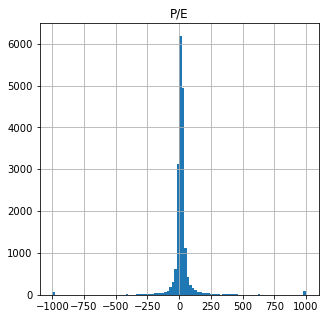

In [21]:
# See one of the distributions
k=x.keys()[2] #14 max
x[k].hist(bins=100, figsize=(5,5))
plt.title(k);

In [22]:
x.describe()

,EV/EBIT,Op. In./(NWC+FA),P/E,P/B,P/S,Op. In./Interest Expense,Working Capital Ratio,RoE,ROCE,Debt/Equity,Debt Ratio,Cash Ratio,Asset Turnover,Gross Profit Margin,(CA-CL)/TA,RE/TA,EBIT/TA,Book Equity/TL
count,18520.000000,18520.000000,18520.000000,18520.000000,18520.000000,18520.000000,18520.000000,18520.000000,18520.000000,18520.000000,18520.000000,18520.000000,18520.000000,18520.000000,18520.000000,18520.000000,18520.000000,18520.000000
mean,13.308929,0.172849,17.279793,4.066544,14.936453,26.129201,2.710205,0.025857,0.119500,2.326597,2.706315,1.406278,36.242589,0.395642,0.216920,-0.329447,0.022236,1.642692
std,68.992336,0.862385,118.525260,11.148703,72.838635,185.561291,3.025720,0.829740,0.167976,7.070579,3.180994,2.813069,219.397664,0.253099,0.263834,2.194917,0.253734,2.528903
min,-500.000000,-5.000000,-1000.000000,-50.000000,0.000000,-200.000000,0.000014,-5.000000,0.000000,0.000000,0.000000,0.000000,-2000.000000,0.000000,-1.500000,-20.000000,-2.000000,-2.000000
25%,5.303265,0.041090,-0.571012,1.409476,0.831732,-1.300782,1.216785,-0.010726,0.018460,0.478871,1.433834,0.181284,2.229667,0.212145,0.042358,-0.134980,0.012944,0.433834
50%,13.160914,0.161155,16.762580,2.488319,1.751794,4.017842,1.858020,0.094263,0.085584,1.050792,1.850300,0.525829,5.758851,0.371177,0.181869,0.139159,0.065404,0.850300
75%,21.153490,0.343049,27.389113,4.531762,3.883610,13.991677,3.025441,0.183630,0.159590,2.017553,2.723004,1.363707,11.685376,0.579496,0.366945,0.392968,0.119491,1.723004
max,500.000000,5.000000,1000.000000,100.000000,500.000000,800.000000,30.000000,5.000000,2.000000,100.000000,50.000000,30.000000,2000.000000,3.000000,0.988949,2.000000,1.000000,20.000000


# DESPUES

In [23]:
x

,EV/EBIT,Op. In./(NWC+FA),P/E,P/B,P/S,Op. In./Interest Expense,Working Capital Ratio,RoE,ROCE,Debt/Equity,Debt Ratio,Cash Ratio,Asset Turnover,Gross Profit Margin,(CA-CL)/TA,RE/TA,EBIT/TA,Book Equity/TL
0,8.389552,0.297085,8.983232,2.432739,1.078175,79.500000,2.392481,0.270809,0.145323,1.738179,1.575315,1.074436,7.007282,0.553516,0.264307,0.398316,0.117739,0.575315
1,161.418182,0.012761,-330.374194,4.073827,2.285561,0.796610,3.527159,-0.012331,0.010171,2.027844,1.493135,2.219947,5.302959,0.511493,0.372832,0.362585,0.008671,0.493135
2,19.788151,0.139203,20.694883,4.374320,2.600165,7.447368,2.000973,0.211372,0.116135,1.996292,1.500929,0.859228,5.555102,0.538207,0.318276,0.355198,0.079208,0.500929
3,9.630571,0.226045,11.832164,2.774363,1.810151,14.875000,3.031573,0.234476,0.152909,1.098471,1.910356,1.919978,6.575547,0.533485,0.412057,0.491995,0.121895,0.910356
4,12.630608,0.286923,12.423886,2.762727,2.088763,12.163043,2.445325,0.222372,0.131320,1.032015,1.968978,1.241944,5.891753,0.525518,0.259681,0.522494,0.107726,0.968978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18515,-0.335651,-0.701331,-1.841155,1.275704,500.000000,42.023160,6.884329,-0.692882,0.000000,0.168846,6.922574,6.144881,0.231206,0.000000,0.850020,-1.751025,-0.607070,5.922574
18516,-0.271501,-0.455408,-2.410810,1.050584,500.000000,22.547108,7.219675,-0.435780,0.000000,0.160957,7.212825,5.810440,0.000000,0.000000,0.854534,-1.718639,-0.392706,6.212825
18517,17.993625,1.973522,22.558857,33.893509,7.090559,6.168276,2.078719,1.502448,1.824561,0.821501,2.217283,1.381922,124.638298,0.794341,0.486505,-0.270019,1.000000,1.217283
18518,17.690044,1.270833,19.954644,20.515204,5.971951,67.337662,2.051267,1.028092,0.845289,1.072005,1.932831,1.450379,38.970696,0.810822,0.381331,0.252662,0.538673,0.932831


In [24]:
y

,Ticker,Perf
0,A,0.764005
1,A,0.373311
2,A,-0.152369
3,A,0.185295
4,A,0.416215
...,...,...
18515,ZYNE,-0.247917
18516,ZYNE,0.268698
18517,ZYXI,-0.008791
18518,ZYXI,1.337917


# Probar la funcion power transformer para ver si los datos tienen buenas distribuciones. 

Muchos algoritmos no funcionan correctamente si los datos no tienen una adecuada distribución.

In [25]:
y.to_csv("Annual_Stock_Price_Performance_Percentage.csv")
x.to_csv("Annual_Stock_Price_Fundamentals_Ratios.csv")

In [26]:
# Write code to plot out all distributions of X in a nice diagram
from sklearn.preprocessing import PowerTransformer
transformer = PowerTransformer()
x_t=pd.DataFrame(transformer.fit_transform(x), columns=x.keys())

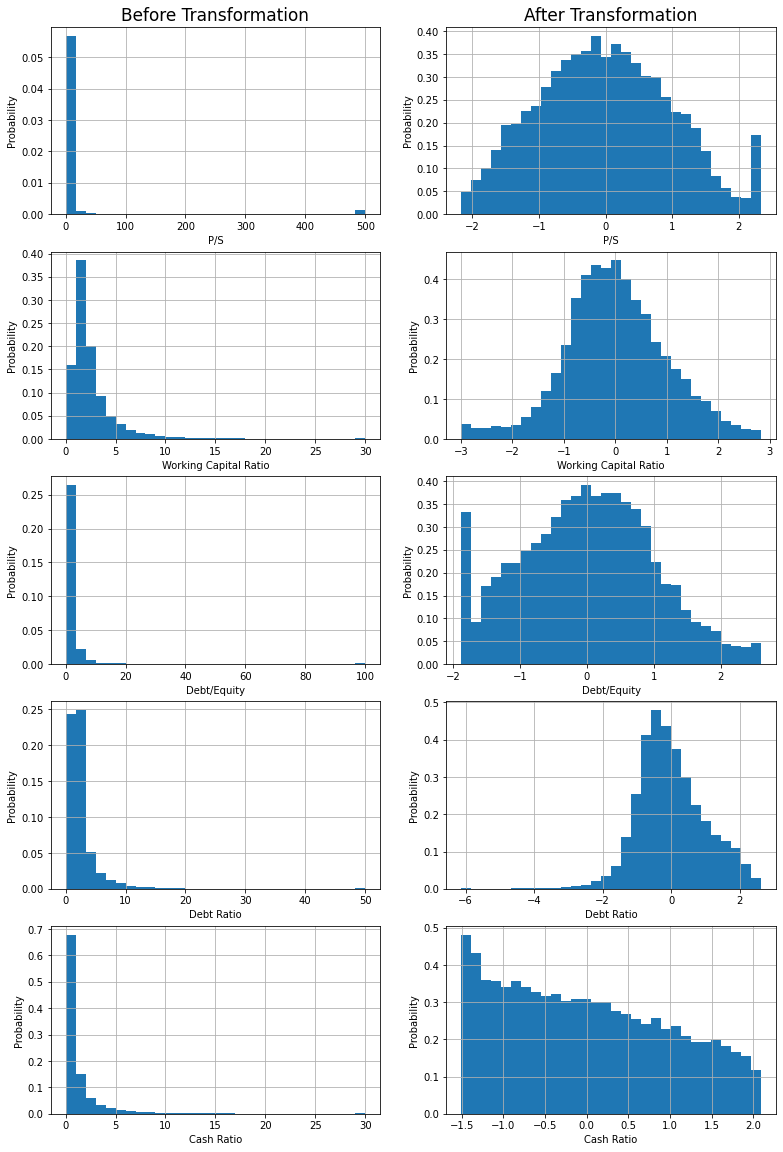

In [27]:
def plotFunc(n, myDatFrame):
    myKey = myDatFrame.keys()[n]
    plt.hist(myDatFrame[myKey], density=True, bins=30)
    plt.grid()
    plt.xlabel(myKey)
    plt.ylabel('Probability')

plt.figure(figsize=(13,20))
plotsIwant=[4,6,9,10,11]
j=1
for i in plotsIwant:
    plt.subplot(len(plotsIwant),2,2*j-1)
    plotFunc(i,x)
    if j==1:
        plt.title('Before Transformation',fontsize=17)
    plt.subplot(len(plotsIwant),2,2*j)
    plotFunc(i,x_t)
    if j==1:
        plt.title('After Transformation',fontsize=17)
    j+=1
    
plt.savefig('Transformat_Dists.png', dpi=300)